# GeoPandas demo



In [1]:
%matplotlib inline

import pandas as pd

import geopandas
from shapely.geometry import Point, Polygon

pd.options.display.max_rows = 10

## Read and write GIS file formats

GeoPandas can read and write many different GIS file formats by relying on the `fiona` library (which is an interface to GDAL/OGR).

For example, let's start by reading a GeoJSON file about the administrative districts in Paris (https://opendata.paris.fr/explore/dataset/quartier_paris/) and some real-time information about the public bicycle sharing system in Paris (vélib, https://opendata.paris.fr/explore/dataset/stations-velib-disponibilites-en-temps-reel/information/) (both are included in the `/data` directory as well):

In [2]:
stations = geopandas.read_file("data/stations-velib-disponibilites-en-temps-reel.geojson")

In [3]:
stations[['status', 'name', 'bike_stands', 'available_bikes', 'geometry']].head()

status                                 name  bike_stands  available_bikes  \
0    OPEN               14002 - RASPAIL QUINET           44                4   
1    OPEN  20503 - COURS DE VINCENNES PYRÉNÉES           21                3   
2    OPEN             20011 - PYRÉNÉES-DAGORNO           21                0   
3  CLOSED        31008 - VINCENNES (MONTREUIL)           56                0   
4    OPEN          43006 - MINIMES (VINCENNES)           28               27   

                              geometry  
0  POINT (2.32955509721 48.8391991672)  
1   POINT (2.40590731702 48.847724969)  
2   POINT (2.40516852064 48.855501354)  
3   POINT (2.43736866129 48.857702134)  
4  POINT (2.43079345113 48.8414868563)

In [4]:
quartiers = geopandas.read_file("data/quartier_paris.geojson")

In [5]:
quartiers.head()

n_sq_qu    perimetre  objectid     longueur  c_qu       surface  \
0  750000047  6155.005036        29  6154.591387    47  1.902932e+06   
1  750000001  5057.549475        41  5057.332772     1  8.690007e+05   
2  750000076  4435.273252        79  4435.143641    76  1.294988e+06   
3  750000065  5264.597082        68  5264.463406    65  1.465071e+06   
4  750000010  2139.625388        50  2139.535591    10  2.717503e+05   

     n_sq_ar  c_quinsee                    l_qu  c_ar  \
0  750000012    7511203                   Bercy    12   
1  750000001    7510101  St-Germain-l'Auxerrois     1   
2  750000019    7511904                  Combat    19   
3  750000017    7511701                  Ternes    17   
4  750000003    7510302          Enfants-Rouges     3   

                                            geometry  
0  POLYGON ((2.391141037839471 48.82611264577471,...  
1  POLYGON ((2.344593389828428 48.85404991486192,...  
2  POLYGON ((2.388343313526396 48.88056667377272,...  
3  POLYGON ((2.295039618663717 48.87377869547587,...  
4  POLYGON ((2.367101341254551 48.86162755885409,...

## What's a GeoDataFrame and GeoSeries?

- `GeoDataFrame` is a DataFrame which has a 'geometry' column. The `.geometry` attribute returns a GeoSeries (the column name itself is not necessarily 'geometry')
- `GeoSeries` is a Series that holds (shapely) geometry objects (Points, LineStrings, Polygons, ...)

In [6]:
type(stations)

geopandas.geodataframe.GeoDataFrame

In [7]:
stations.geometry

0       POINT (2.32955509721 48.8391991672)
1        POINT (2.40590731702 48.847724969)
2        POINT (2.40516852064 48.855501354)
3        POINT (2.43736866129 48.857702134)
4       POINT (2.43079345113 48.8414868563)
                       ...                 
1221    POINT (2.38257893505 48.8448673196)
1222     POINT (2.35634514417 48.821039287)
1223    POINT (2.33141820471 48.8589429862)
1224    POINT (2.27854960082 48.8274705017)
1225    POINT (2.32524904508 48.8662852212)
Name: geometry, Length: 1226, dtype: object

In [8]:
type(stations.geometry)

geopandas.geoseries.GeoSeries

In [9]:
type(stations.geometry[0])

shapely.geometry.point.Point

## It's still a DataFrame

We still have our pandas functionality that we can use on the geospatial dataset (e.g. boolean filtering).

In [10]:
stations = stations[stations['status'] == 'OPEN'].copy()

A histogram showing the distribution of the number of bike stands in the stations:

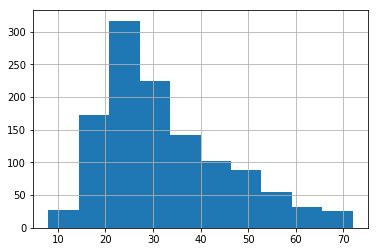

In [11]:
stations['bike_stands'].hist()

## But now has access to spatial predicates and operations

For example, we can access the area of the different quartiers:

In [12]:
quartiers.geometry.area

0     0.000233
1     0.000107
2     0.000159
3     0.000180
4     0.000033
        ...   
75    0.000035
76    0.000132
77    0.000169
78    0.000098
79    0.000093
Length: 80, dtype: float64

Or calculate the distance from a certain point to all the bike stations.

I used `geopy` to localize the Notre Dame:

```python
>>> from geopy.geocoders import Nominatim
>>> geolocator = Nominatim()
>>> location = geolocator.geocode("Notre Dame Paris")
>>> notre_dame = Point(location.longitude, location.latitude)
>>> print(notre_dame)
POINT (2.35005149954546 48.85293695)
```

In [13]:
notre_dame = Point(2.35005149954546, 48.85293695)

In [14]:
stations.geometry.distance(notre_dame)

0       0.024674
1       0.056098
2       0.055177
4       0.081550
5       0.070769
          ...   
1221    0.033513
1222    0.032513
1223    0.019577
1224    0.075902
1225    0.028166
Length: 1186, dtype: float64

Or check in which quartier the Notre Dame is located:

In [15]:
quartiers.contains(notre_dame)

0     False
1     False
2     False
3     False
4     False
      ...  
75    False
76    False
77    False
78    False
79    False
Length: 80, dtype: bool

In [16]:
quartiers[quartiers.contains(notre_dame)]

n_sq_qu    perimetre  objectid     longueur  c_qu        surface  \
5  750000016  3283.163371        56  3282.999717    16  378252.153674   

     n_sq_ar  c_quinsee        l_qu  c_ar  \
5  750000004    7510404  Notre-Dame     4   

                                            geometry  
5  POLYGON ((2.361313701339139 48.84858030437791,...

Many spatial predicates and operations:

- Predicates: contains, covers, crosses, intersects, equals, overlaps, touches, within
- Operations: difference, intersection, union, buffer, distance, length, area, interpolate, project, relate, 


## Visualize your geospatial data

GeoPandas allows you to quickly visualize your geometries:

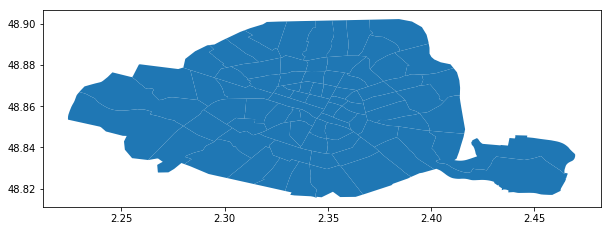

In [17]:
quartiers.plot(figsize=(10, 10))

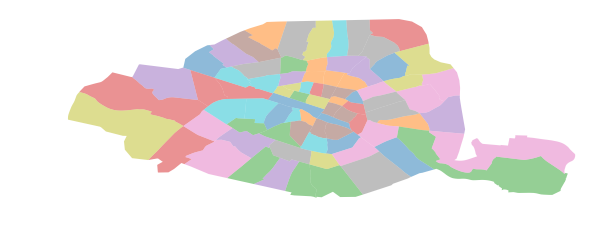

In [18]:
ax = quartiers.plot(figsize=(10, 10), cmap='tab10', alpha=0.5)
ax.set_axis_off()

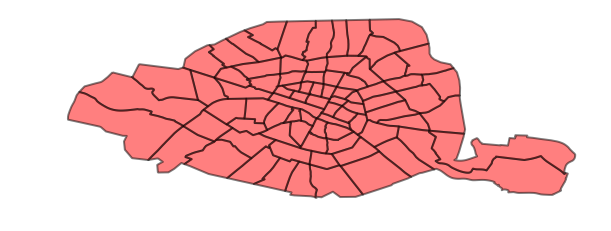

In [19]:
ax = quartiers.plot(figsize=(10, 10), edgecolor='k',
                    facecolor='r', alpha=0.5, linewidth=2)
ax.set_axis_off()

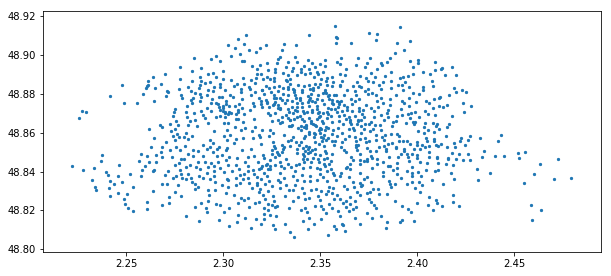

In [20]:
stations.plot(markersize=5, figsize=(10, 10))

### Add a background map

In [21]:
import contextily as ctx

def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))


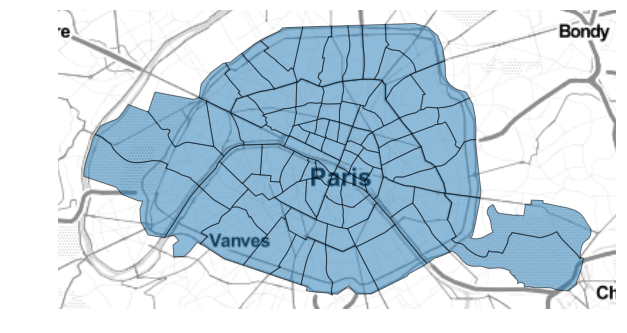

In [22]:
ax = quartiers.to_crs(epsg=3857).plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
add_basemap(ax, zoom=11, url=ctx.sources.ST_TONER_LITE)
ax.set_axis_off()

### Adding OpenStreetMap street network

It would be nice to add the street network to the figure above. Therefore, I downloaded, using the `osmnx` package, the openstreetmap network for Paris, and saved it as a shapefile:

    import osmnx as ox
    G = ox.graph_from_place('Paris, France', network_type='drive')
    ox.save_graph_shapefile(G, 'openstreetmap_paris', folder='.')

In [23]:
streets = geopandas.read_file("data/openstreetmap_paris/edges/")

In [24]:
streets.head()

access bridge        from      highway key lanes              length  \
0   None   None  1245546489      primary   0  None  10.441171286969725   
1   None   None      442371      primary   0     4  218.52200148977164   
2   None   None      442371      primary   0  None   60.98775515463154   
3   None   None      442371      primary   0  None  111.87478765505494   
4   None   None  1760247812  residential   0  None  44.238688986210406   

  maxspeed                                name oneway      osmid   ref  \
0       50                 Boulevard MacDonald   True  191694881  None   
1       50                 Boulevard MacDonald  False   13859914  None   
2       50                 Boulevard MacDonald   True  178237238  None   
3     None  Avenue de la Porte d'Aubervilliers   True   19923111  None   
4     None                    Villa des Lyanes  False  164380899  None   

  service          to tunnel width  \
0    None      442371   None  None   
1    None   209141276   None  None   
2    None  1886061102   None  None   
3    None  3805263959   None  None   
4    None  1760247816   None  None   

                                            geometry  
0  LINESTRING (2.3711204 48.8987287, 2.3710461 48...  
1  LINESTRING (2.3711204 48.8987287, 2.3713436 48...  
2  LINESTRING (2.3711204 48.8987287, 2.3709746 48...  
3  LINESTRING (2.3711204 48.8987287, 2.3711267 48...  
4  LINESTRING (2.4051359 48.863424, 2.4054913 48....

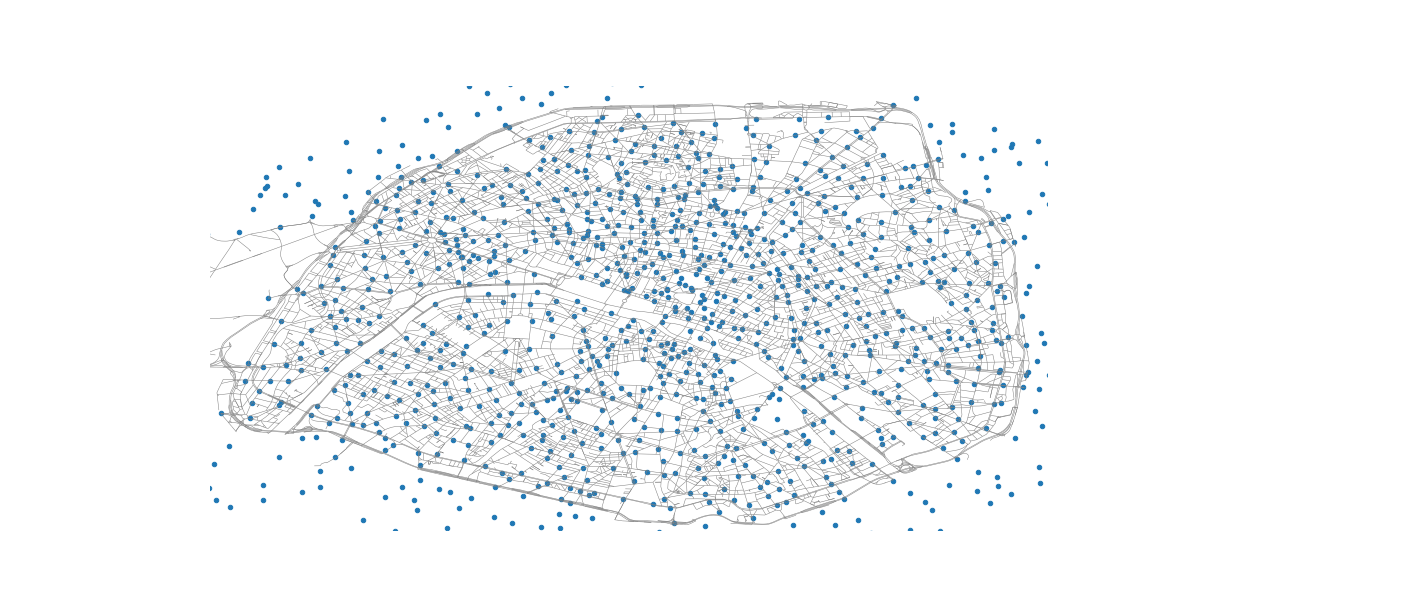

In [25]:
ax = streets.plot(linewidth=0.5, color='grey', figsize=(15, 10))
stations.plot(ax=ax, markersize=20)
ax.set(xlim=(2.25, 2.42), ylim=(48.815, 48.905));
ax.set_axis_off()

### Color the plot based on values

By specifying the `column` keyword, we can color the geometries based on the values of that column:

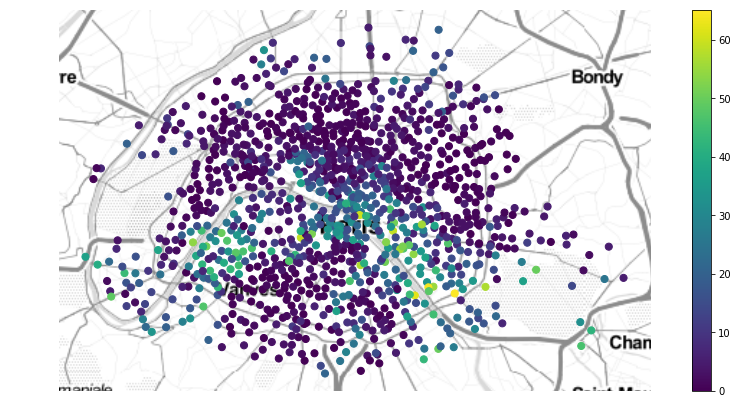

In [26]:
ax = stations.to_crs(epsg=3857).plot(
    column='available_bikes', markersize=50, legend=True, figsize=(15, 7))
add_basemap(ax, zoom=11, url=ctx.sources.ST_TONER_LITE)
ax.set_axis_off()

Or based on categorical values:

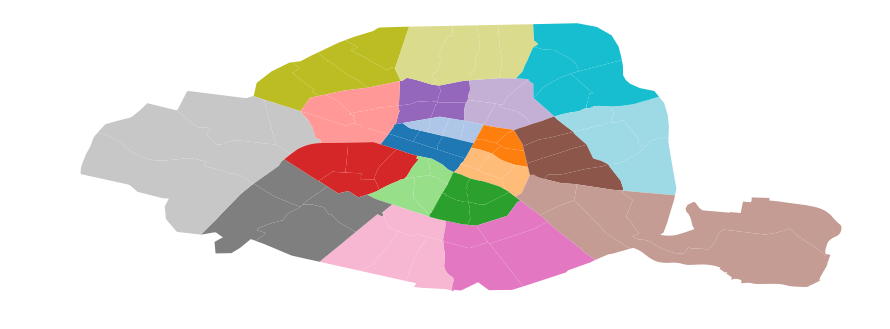

In [27]:
ax = quartiers.plot(column='n_sq_ar', categorical=True, cmap='tab20', figsize=(15, 8))
ax.set_axis_off()

## Spatial joins

GeoPandas includes functionality to perform spatial joins and overlays (`sjoin` and `overlay`).

Here, let's do a spatial join to determine the quartier in which each bike station is located.

In [28]:
stations = geopandas.sjoin(stations,
                           quartiers[['l_qu', 'geometry']].copy(),
                           op='within')

In [29]:
stations.head()

status contract_name                                    name  bonus  \
0     OPEN         Paris                  14002 - RASPAIL QUINET   True   
143   OPEN         Paris  14112 - FAUBOURG SAINT JACQUES CASSINI  False   
293   OPEN         Paris               14033 - DAGUERRE GASSENDI   True   
346   OPEN         Paris     14006 - SAINT JACQUES TOMBE ISSOIRE  False   
429   OPEN         Paris       14111 - DENFERT-ROCHEREAU CASSINI  False   

     bike_stands  number          last_update  available_bike_stands banking  \
0             44   14002  2017-08-26T13:04:34                     39    True   
143           16   14112  2017-08-26T17:35:50                     16    True   
293           38   14033  2017-08-26T17:42:31                     37    True   
346           22   14006  2017-08-26T17:42:11                     22    True   
429           24   14111  2017-08-26T17:41:31                     16    True   

     available_bikes                                   address  \
0                  4      FACE 4 BD EDGAR QUINET - 75014 PARIS   
143                0              24 RUE MECHAIN - 75014 PARIS   
293                1           31 RUE FROIDEVAUX - 75014 PARIS   
346                0  46 BOULEVARD SAINT JACQUES - 75014 PARIS   
429                8              18 RUE CASSINI - 75014 PARIS   

                                geometry  index_right          l_qu  
0    POINT (2.32955509721 48.8391991672)           56  Montparnasse  
143   POINT (2.33798034198 48.835867721)           56  Montparnasse  
293  POINT (2.32829082205 48.8356804442)           56  Montparnasse  
346  POINT (2.33693339125 48.8331903188)           56  Montparnasse  
429  POINT (2.33598303047 48.8375492922)           56  Montparnasse

In [30]:
counts = stations.groupby('l_qu').size()

In [31]:
quartiers = quartiers.merge(counts.reset_index(name='number_bike_stations'))

In [32]:
quartiers.head()

n_sq_qu    perimetre  objectid     longueur  c_qu       surface  \
0  750000047  6155.005036        29  6154.591387    47  1.902932e+06   
1  750000001  5057.549475        41  5057.332772     1  8.690007e+05   
2  750000076  4435.273252        79  4435.143641    76  1.294988e+06   
3  750000065  5264.597082        68  5264.463406    65  1.465071e+06   
4  750000010  2139.625388        50  2139.535591    10  2.717503e+05   

     n_sq_ar  c_quinsee                    l_qu  c_ar  \
0  750000012    7511203                   Bercy    12   
1  750000001    7510101  St-Germain-l'Auxerrois     1   
2  750000019    7511904                  Combat    19   
3  750000017    7511701                  Ternes    17   
4  750000003    7510302          Enfants-Rouges     3   

                                            geometry  number_bike_stations  
0  POLYGON ((2.391141037839471 48.82611264577471,...                     9  
1  POLYGON ((2.344593389828428 48.85404991486192,...                     4  
2  POLYGON ((2.388343313526396 48.88056667377272,...                    13  
3  POLYGON ((2.295039618663717 48.87377869547587,...                    18  
4  POLYGON ((2.367101341254551 48.86162755885409,...                     3

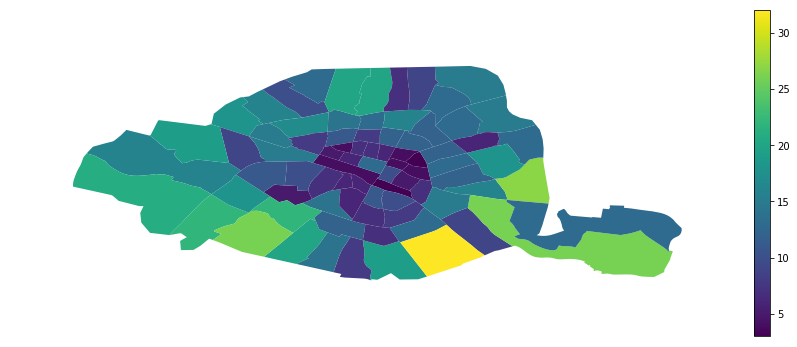

In [31]:
ax = quartiers.plot(column='number_bike_stations', figsize=(15, 6), legend=True)
ax.set_axis_off()

In [32]:
quartiers['number_bike_stations_relative'] = (
    quartiers['number_bike_stations'] / quartiers.geometry.area)

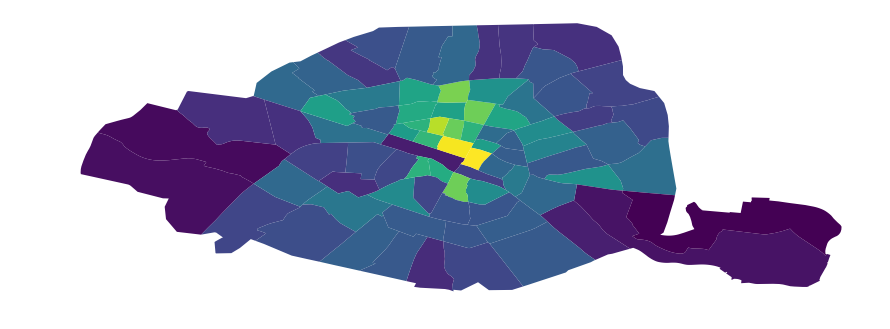

In [33]:
ax = quartiers.plot(column='number_bike_stations_relative',
                    figsize=(15, 6))
ax.set_axis_off()

## Coordinate reference systems

A GeoDataFrame or GeoSeries has a `.crs` attribute which holds (optionally) a description of the coordinate reference system of the geometries:

In [34]:
stations.crs

{'init': 'epsg:4326'}

In [35]:
stations.geometry.head(3)

0      POINT (2.32955509721 48.8391991672)
143     POINT (2.33798034198 48.835867721)
293    POINT (2.32829082205 48.8356804442)
Name: geometry, dtype: object

We can convert this to another reference system using the `to_crs` function. 
For example, let's convert it to the UTM 31U zone reference system (http://epsg.io/32631) which unit is metres.

In [36]:
stations2 = stations.to_crs(epsg=32631)
# or 
# stations.to_crs("+proj=utm +zone=31 +ellps=WGS84 +datum=WGS84 +units=m +no_defs ")

In [37]:
stations2.geometry.head(3)

0       POINT (450804.448740735 5409797.268203795)
143     POINT (451419.446715647 5409421.528587255)
293    POINT (450708.2275807534 5409406.941172979)
Name: geometry, dtype: object

In [38]:
quartiers2 = quartiers.to_crs(epsg=32631)

In [39]:
(quartiers2.geometry.area / 1000**2)

0     1.901972
1     0.868538
2     1.294254
3     1.464259
4     0.271603
        ...   
75    0.282132
76    1.073169
77    1.381170
78    0.796153
79    0.760312
Length: 80, dtype: float64

## Interactive Leaflet.js maps with `folium`

In [40]:
import folium

In [41]:
m = folium.Map([48.8566, 2.3429], zoom_start=12, tiles="OpenStreetMap")
m.choropleth(geo_str=quartiers.to_json(), data=quartiers, columns=['objectid', 'number_bike_stations_relative'],
             key_on='feature.properties.objectid', fill_color='BuGn', highlight=True)

In [42]:
m

## Urban Atlas data

Urban Atlas is providing pan-European comparable land use and land cover data for Large Urban Zones (http://www.eea.europa.eu/data-and-maps/data/urban-atlas)

The data file for Paris is rather big, so I cutted a subset for the center of Paris and saved that again as a shapefile:

```python
urban_atlas_full = geopandas.read_file('/fr001l_paris', vfs='zip:///.../fr001l_paris.zip')
x, y = 3760000, 2890000
us_subset = urban_atlas_full.cx[x-8000 : x+8000, y-8000 : y+8000].copy()
area = Polygon([(x-8000, y-8000), (x+8000, y-8000), (x+8000, y+8000), (x-8000, y+8000)])
us_subset['geometry'] = us_subset.geometry.intersection(area)
us_subset.to_file("fr001l_paris.shp")
```

In [43]:
us = geopandas.read_file("fr001l_paris.shp")

In [44]:
us.head()

CITIES LUZ_OR_CIT   CODE                                  ITEM PROD_DATE  \
0  Paris     FR001L  11100  Continuous Urban Fabric (S.L. > 80%)      2011   
1  Paris     FR001L  11100  Continuous Urban Fabric (S.L. > 80%)      2011   
2  Paris     FR001L  11100  Continuous Urban Fabric (S.L. > 80%)      2011   
3  Paris     FR001L  11100  Continuous Urban Fabric (S.L. > 80%)      2011   
4  Paris     FR001L  11100  Continuous Urban Fabric (S.L. > 80%)      2011   

     SHAPE_LEN    SHAPE_AREA  \
0   852.179314  15717.297723   
1   779.619910  21761.331806   
2  1107.783935  37965.185195   
3   239.287807   3104.207018   
4   322.472230   5353.457105   

                                            geometry  
0  POLYGON ((3763476.757668196 2882372.206915549,...  
1  POLYGON ((3755750.795373401 2890571.441747018,...  
2  POLYGON ((3759045.014574341 2894223.898634031,...  
3  POLYGON ((3763468.876496253 2889310.004122872,...  
4  POLYGON ((3756953.575115261 2891043.84315913, ...

In [45]:
us.crs

{'ellps': 'GRS80',
 'lat_0': 52,
 'lon_0': 10,
 'no_defs': True,
 'proj': 'laea',
 'units': 'm',
 'x_0': 4321000,
 'y_0': 3210000}

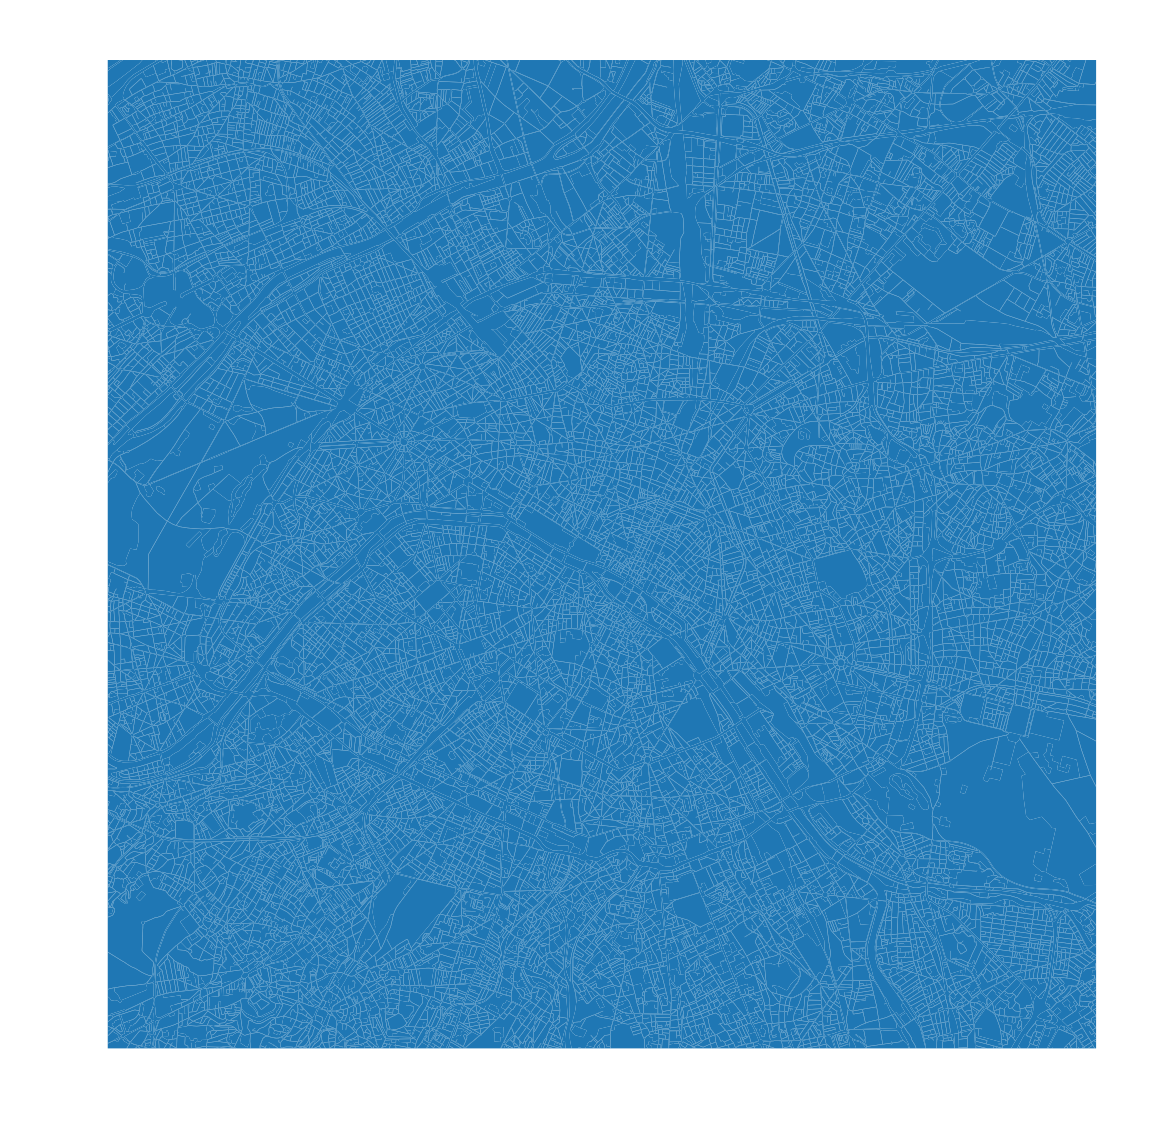

In [46]:
ax = us.plot(figsize=(20,20))
ax.set_axis_off()

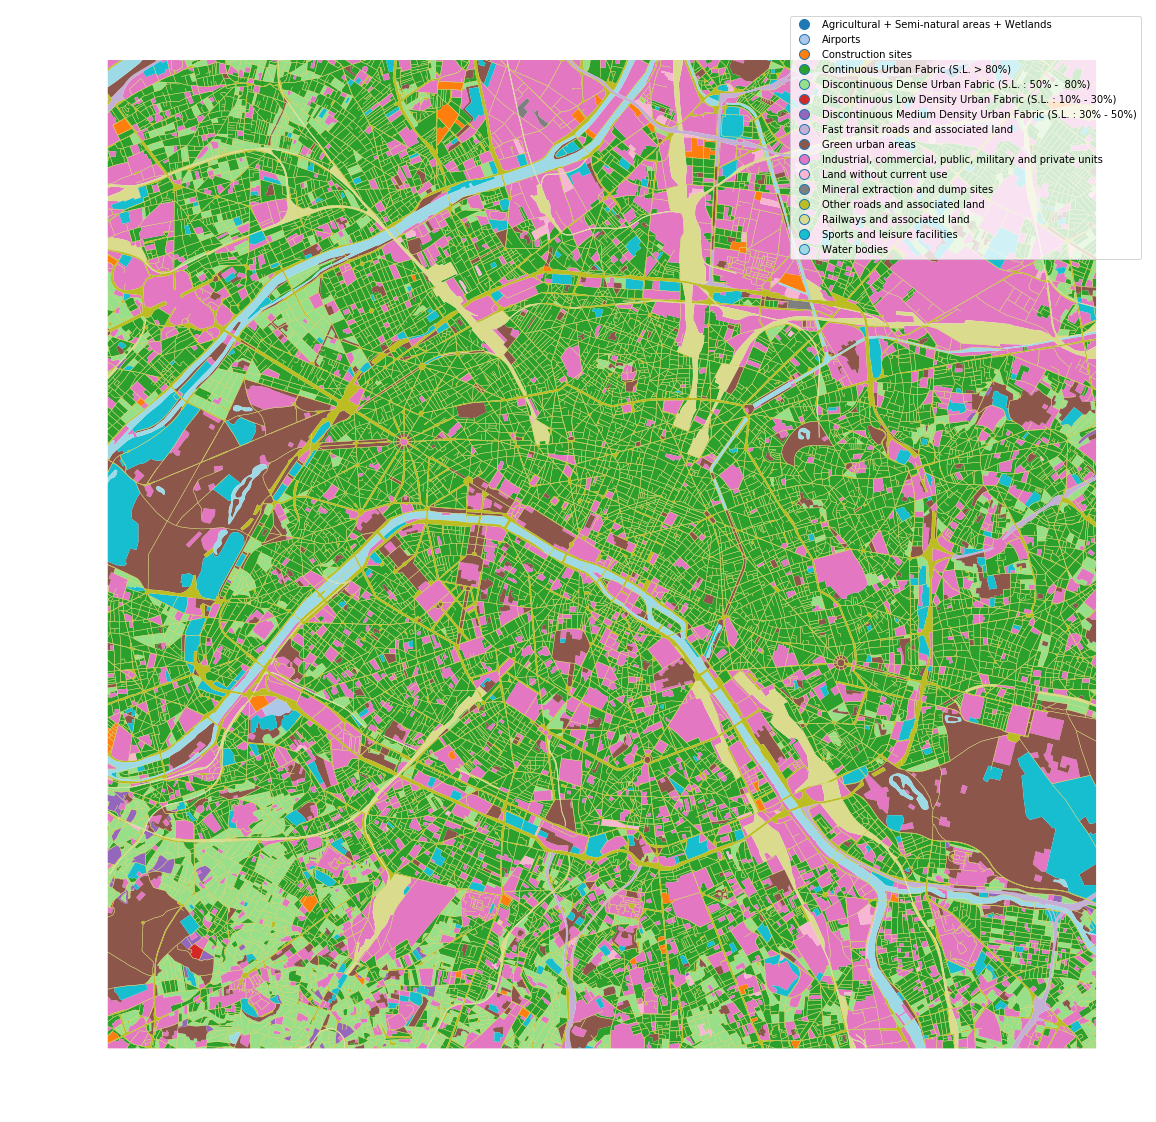

In [47]:
ax = us.plot(column='ITEM', figsize=(20,20), legend=True, cmap='tab20')
ax.set_axis_off()

In [48]:
pd.options.display.max_rows = 60

In [49]:
us.ITEM.value_counts()

Continuous Urban Fabric (S.L. > 80%)                            10228
Industrial, commercial, public, military and private units       2678
Discontinuous Dense Urban Fabric (S.L. : 50% -  80%)             1414
Green urban areas                                                 731
Sports and leisure facilities                                     322
Water bodies                                                      125
Railways and associated land                                      123
Other roads and associated land                                    94
Land without current use                                           72
Discontinuous Medium Density Urban Fabric (S.L. : 30% - 50%)       61
Construction sites                                                 52
Fast transit roads and associated land                             28
Mineral extraction and dump sites                                   3
Discontinuous Low Density Urban Fabric (S.L. : 10% - 30%)           2
Agricultural + Semi-

In [50]:
us.groupby('ITEM')['geometry'].agg(lambda x: x.area.sum()).sort_values(ascending=False)

ITEM
Continuous Urban Fabric (S.L. > 80%)                            9.977743e+07
Industrial, commercial, public, military and private units      5.566733e+07
Other roads and associated land                                 3.229025e+07
Green urban areas                                               2.225923e+07
Discontinuous Dense Urban Fabric (S.L. : 50% -  80%)            1.805155e+07
Sports and leisure facilities                                   1.016356e+07
Railways and associated land                                    7.431319e+06
Water bodies                                                    5.779798e+06
Fast transit roads and associated land                          1.785006e+06
Construction sites                                              9.373305e+05
Land without current use                                        8.906937e+05
Discontinuous Medium Density Urban Fabric (S.L. : 30% - 50%)    7.013594e+05
Mineral extraction and dump sites                               1.02031

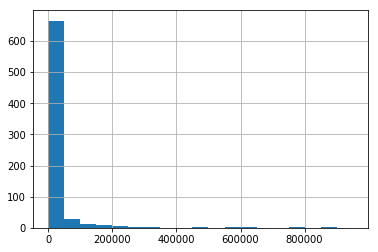

In [51]:
us[us.ITEM == 'Green urban areas'].geometry.area.hist(bins=np.arange(0, 1000000, 50000))